In [72]:
import IPython
import pandas as pd
import numpy as np
from statistics import mode
import matplotlib.pyplot as plt  
from sklearn.preprocessing import MinMaxScaler

In [73]:
# load modified file with some pre-processing completed
df = pd.read_csv("modify.csv", index_col=0)
df.shape

(100120, 52)

In [74]:
df.head(10).T

,0,1,2,3,4,5,6,7,8,9
encounter_id,2278392,149190,64410,500364,16680,35754,55842,63768,12522,15738
patient_nbr,8222157,55629189,86047875,82442376,42519267,82637451,84259809,114882984,48330783,63555939
race,Caucasian,Caucasian,AfricanAmerican,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian
gender,0,0,0,1,1,1,1,1,0,0
age,1,2,3,4,5,6,7,8,9,10
admission_type_id,6,1,1,1,1,2,3,1,2,3
discharge_disposition_id,25,1,1,1,1,1,1,1,1,3
admission_source_id,1,7,7,7,7,2,2,7,4,4
time_in_hospital,1,3,2,2,1,3,4,5,13,12
num_lab_procedures,41,59,11,44,51,31,70,73,68,33


In [75]:
# convert data type of nominal features in dataframe to 'object' type
for i in ('encounter_id', 'patient_nbr', 'gender', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id',\
          'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', \
          'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose','miglitol', \
          'troglitazone', 'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin', \
          'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', \
          'age', 'A1Cresult', 'max_glu_serum', 'level1_diag1', 'level1_diag2', 'level1_diag3', 'level2_diag1', 'level2_diag2', 'level2_diag3' ):
    df[i] = df[i].astype('object')

In [76]:
df.dtypes

encounter_id                object
patient_nbr                 object
race                        object
gender                      object
age                         object
admission_type_id           object
discharge_disposition_id    object
admission_source_id         object
time_in_hospital             int64
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride                 object
acetohexamide               object
glipizide                   object
glyburide           

In [77]:
"""
This code converts age as categorical variable to a continuous approximation by assuming mid-point of each age-category as
the actual age value. This is done to avoid having to deal with age as a dummy variable in the models which makes
interpretation very cumbersome. Also, since age category is not purely nominal but ordinal, we do not want to lose that
information by treating it as a simple categorical variable.
"""

# convert age back to integer type
df['age'] = df['age'].astype('int64')
print(df.age.value_counts())
# convert age categories to mid-point values
age_dict = {1:5, 2:15, 3:25, 4:35, 5:45, 6:55, 7:65, 8:75, 9:85, 10:95}
df['age'] = df.age.map(age_dict)
print(df.age.value_counts())

8     25564
7     22186
6     17102
9     16708
5      9626
4      3765
10     2669
3      1650
2       690
1       160
Name: age, dtype: int64
75    25564
65    22186
55    17102
85    16708
45     9626
35     3765
95     2669
25     1650
15      690
5       160
Name: age, dtype: int64


In [78]:
# get list of only numeric features
num_col = list(set(list(df._get_numeric_data().columns))- {'readmitted'})

In [79]:
num_col

['number_emergency',
 'service_utilization',
 'number_inpatient',
 'num_lab_procedures',
 'num_medications',
 'number_diagnoses',
 'num_procedures',
 'time_in_hospital',
 'number_outpatient',
 'age']

In [80]:
# Removing skewnewss and kurtosis using log transformation if it is above a threshold value (2)

statdataframe = pd.DataFrame()
statdataframe['numeric_column'] = num_col
skew_before = []
skew_after = []

kurt_before = []
kurt_after = []

standard_deviation_before = []
standard_deviation_after = []

log_transform_needed = []

log_type = []

for i in num_col:
    skewval = df[i].skew()
    skew_before.append(skewval)
    
    kurtval = df[i].kurtosis()
    kurt_before.append(kurtval)
    
    sdval = df[i].std()
    standard_deviation_before.append(sdval)
    
    if (abs(skewval) >2) & (abs(kurtval) >2):
        log_transform_needed.append('Yes')
        
        if len(df[df[i] == 0])/len(df) <=0.02:
            log_type.append('log')
            skewvalnew = np.log(pd.DataFrame(df[train_data[i] > 0])[i]).skew()
            skew_after.append(skewvalnew)
            
            kurtvalnew = np.log(pd.DataFrame(df[train_data[i] > 0])[i]).kurtosis()
            kurt_after.append(kurtvalnew)
            
            sdvalnew = np.log(pd.DataFrame(df[train_data[i] > 0])[i]).std()
            standard_deviation_after.append(sdvalnew)
            
        else:
            log_type.append('log1p')
            skewvalnew = np.log1p(pd.DataFrame(df[df[i] >= 0])[i]).skew()
            skew_after.append(skewvalnew)
        
            kurtvalnew = np.log1p(pd.DataFrame(df[df[i] >= 0])[i]).kurtosis()
            kurt_after.append(kurtvalnew)
            
            sdvalnew = np.log1p(pd.DataFrame(df[df[i] >= 0])[i]).std()
            standard_deviation_after.append(sdvalnew)
            
    else:
        log_type.append('NA')
        log_transform_needed.append('No')
        
        skew_after.append(skewval)
        kurt_after.append(kurtval)
        standard_deviation_after.append(sdval)

statdataframe['skew_before'] = skew_before
statdataframe['kurtosis_before'] = kurt_before
statdataframe['standard_deviation_before'] = standard_deviation_before
statdataframe['log_transform_needed'] = log_transform_needed
statdataframe['log_type'] = log_type
statdataframe['skew_after'] = skew_after
statdataframe['kurtosis_after'] = kurt_after
statdataframe['standard_deviation_after'] = standard_deviation_after

In [81]:
statdataframe

,numeric_column,skew_before,kurtosis_before,standard_deviation_before,log_transform_needed,log_type,skew_after,kurtosis_after,standard_deviation_after
0,number_emergency,22.842251,1185.246374,0.935517,Yes,log1p,3.661064,16.276610,0.315405
1,service_utilization,5.334724,67.779770,2.292730,Yes,log1p,1.119136,0.547353,0.662373
2,number_inpatient,3.626402,20.833542,1.261825,Yes,log1p,1.450492,1.405364,0.510433
3,num_lab_procedures,-0.241491,-0.253099,19.620228,No,NA,-0.241491,-0.253099,19.620228
4,num_medications,1.333039,3.523472,8.092612,No,NA,1.333039,3.523472,8.092612
5,number_diagnoses,-0.867785,-0.109005,1.938211,No,NA,-0.867785,-0.109005,1.938211
6,num_procedures,1.326020,0.890773,1.700335,No,NA,1.326020,0.890773,1.700335
7,time_in_hospital,1.137931,0.871189,2.974528,No,NA,1.137931,0.871189,2.974528
8,number_outpatient,8.818291,148.558544,1.263973,Yes,log1p,2.733914,7.804218,0.429394
9,age,-0.626715,0.274302,15.947496,No,NA,-0.626715,0.274302,15.947496


In [82]:
# performing the log transformation for the columns determined to be needing it above.

for i in range(len(statdataframe)):
    if statdataframe['log_transform_needed'][i] == 'Yes':
        colname = str(statdataframe['numeric_column'][i])
        
        if statdataframe['log_type'][i] == 'log':
            df = df[df[colname] > 0]
            df[colname + "_log"] = np.log(df[colname])
            
        elif statdataframe['log_type'][i] == 'log1p':
            df = df[df[colname] >= 0]
            df[colname + "_log1p"] = np.log1p(df[colname])

In [83]:
df = df.drop(['number_outpatient', 'number_inpatient', 'number_emergency','service_utilization'], axis = 1)

In [84]:
df.shape

(100120, 52)

In [85]:
# get list of only numeric features
numerics = list(set(list(df._get_numeric_data().columns))- {'readmitted'})

In [86]:
numerics

['number_emergency_log1p',
 'num_lab_procedures',
 'num_medications',
 'number_inpatient_log1p',
 'number_diagnoses',
 'num_procedures',
 'number_outpatient_log1p',
 'time_in_hospital',
 'service_utilization_log1p',
 'age']

In [87]:
# apply minimax scaling to all numeric features
for feature in numerics:
    scaler = MinMaxScaler()
    df[numerics] = scaler.fit_transform(df[numerics])

In [88]:
# show list of features that are categorical
df.encounter_id = df.encounter_id.astype('int64')
df.patient_nbr = df.patient_nbr.astype('int64')
df.diabetesMed = df.diabetesMed.astype('int64')
df.change = df.change.astype('int64')
df.dtypes

encounter_id                   int64
patient_nbr                    int64
race                          object
gender                        object
age                          float64
admission_type_id             object
discharge_disposition_id      object
admission_source_id           object
time_in_hospital             float64
num_lab_procedures           float64
num_procedures               float64
num_medications              float64
diag_1                        object
diag_2                        object
diag_3                        object
number_diagnoses             float64
max_glu_serum                 object
A1Cresult                     object
metformin                     object
repaglinide                   object
nateglinide                   object
chlorpropamide                object
glimepiride                   object
acetohexamide                 object
glipizide                     object
glyburide                     object
tolbutamide                   object
p

In [89]:
df.A1Cresult.value_counts()

-99    83243
 1     11935
 0      4942
Name: A1Cresult, dtype: int64

In [90]:
"""
For dealing with multiple encounters of same patient, we collapse these multiple encounters into a single one, such that
the resultant encounter retains the key features of its constituents. For situations where this could not be achieved
effectively, we have dropped those patients altogether. An example is where the category of primary diagnosis
(not exact disease) is different across multiple encounters of the same patient.
"""
# create a rule dictionary for combining patient records with multiple encounters

ruledict = {
    "patient_nbr":"first",
    "race": "first",
    "gender": "first",
    "age": "mean",
    "admission_type_id" : "first",
    "discharge_disposition_id" : "first",
    "admission_source_id" : "first",
    "time_in_hospital": "mean",
    "num_lab_procedures" : "mean",
    "num_procedures" : "mean",
    "num_medications" : "mean",
    "number_outpatient_log1p" : "mean",
    "number_emergency_log1p" : "mean", 
    "number_inpatient_log1p" : "mean",
    "diag_1" : ','.join,
    "diag_2" : ','.join,
    "diag_3" : ','.join,
    "number_diagnoses" : "mean", 
#     "max_glu_serum" : ','.join,
#     "A1Cresult" : ','.join,
#     "metformin" : ','.join,
#     "repaglinide" : ','.join,
#     "nateglinide" : ','.join,
#     "chlorpropamide" : ','.join,
#     "glimepiride" : ','.join,
#     "acetohexamide" : "mean",
#     "glipizide" : ','.join,
#     "glyburide" : ','.join,
#     "tolbutamide" : "mean",
#     "pioglitazone" : ','.join,
#     "rosiglitazone" : ','.join,
#     "acarbose" : ','.join,
#     "miglitol" : ','.join,
#     "troglitazone" : "mean",
#     "tolazamide" : ','.join,
#     "insulin" : ','.join,
#     "glyburide-metformin" : ','.join,
#     "glipizide-metformin" : "mean",
#     "glimepiride-pioglitazone" : "mean",
#     "metformin-rosiglitazone" : "mean",
#     "metformin-pioglitazone" : "mean",
    "change" : "mean", # gives proportion of change as this is a binary variable
    "diabetesMed": "mean", # same logic as above
    "readmitted" : "mean", # simialr logic as above but here values range = 0-2
    "service_utilization_log1p" : "mean",
    "level1_diag1": lambda x: x.iloc[0] if x.nunique()==1 else np.NaN,
    "level1_diag2": lambda x: x.iloc[0] if x.nunique()==1 else np.NaN,
    "level1_diag3": lambda x: x.iloc[0] if x.nunique()==1 else np.NaN,
    "level2_diag1": lambda x: x.iloc[0] if x.nunique()==1 else np.NaN,
    "level2_diag2": lambda x: x.iloc[0] if x.nunique()==1 else np.NaN,
    "level2_diag3": lambda x: x.iloc[0] if x.nunique()==1 else np.NaN,
    "max_glu_serum": lambda x: x.max(),
    "A1Cresult": lambda x: x.max(),
}

In [91]:
df_p = df.groupby('patient_nbr').agg(ruledict).reset_index(drop = True)

In [92]:
df_p[df_p.patient_nbr==5220].T

,12
patient_nbr,5220
race,Caucasian
gender,1
age,0.75
admission_type_id,1
discharge_disposition_id,1
admission_source_id,7
time_in_hospital,0.346154
num_lab_procedures,0.307252
num_procedures,0.291667


In [93]:
df_p.isnull().sum()

patient_nbr                      0
race                             0
gender                           0
age                              0
admission_type_id                0
discharge_disposition_id         0
admission_source_id              0
time_in_hospital                 0
num_lab_procedures               0
num_procedures                   0
num_medications                  0
number_outpatient_log1p          0
number_emergency_log1p           0
number_inpatient_log1p           0
diag_1                           0
diag_2                           0
diag_3                           0
number_diagnoses                 0
change                           0
diabetesMed                      0
readmitted                       0
service_utilization_log1p        0
level1_diag1                 11612
level1_diag2                 12078
level1_diag3                 12873
level2_diag1                 12933
level2_diag2                 13522
level2_diag3                 14214
max_glu_serum       

In [94]:
# drop the records where multiple encounters had dis-similar diagnoses
df_p = df_p.drop(df_p[(df_p.level1_diag1.isnull())].index)
df_p.shape

(58830, 30)

In [95]:
df_p.isnull().sum()

patient_nbr                     0
race                            0
gender                          0
age                             0
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient_log1p         0
number_emergency_log1p          0
number_inpatient_log1p          0
diag_1                          0
diag_2                          0
diag_3                          0
number_diagnoses                0
change                          0
diabetesMed                     0
readmitted                      0
service_utilization_log1p       0
level1_diag1                    0
level1_diag2                 2962
level1_diag3                 3424
level2_diag1                 1321
level2_diag2                 3532
level2_diag3                 3904
max_glu_serum                   0
A1Cresult     

In [96]:
df_p.drop(['level1_diag2','level1_diag3','level2_diag1','level2_diag2','level2_diag3','diag_1','diag_2','diag_3'], axis=1, inplace=True)

In [97]:
df_p.isnull().sum()

patient_nbr                  0
race                         0
gender                       0
age                          0
admission_type_id            0
discharge_disposition_id     0
admission_source_id          0
time_in_hospital             0
num_lab_procedures           0
num_procedures               0
num_medications              0
number_outpatient_log1p      0
number_emergency_log1p       0
number_inpatient_log1p       0
number_diagnoses             0
change                       0
diabetesMed                  0
readmitted                   0
service_utilization_log1p    0
level1_diag1                 0
max_glu_serum                0
A1Cresult                    0
dtype: int64

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100120 entries, 0 to 101765
Data columns (total 52 columns):
encounter_id                 100120 non-null int64
patient_nbr                  100120 non-null int64
race                         100120 non-null object
gender                       100120 non-null object
age                          100120 non-null float64
admission_type_id            100120 non-null object
discharge_disposition_id     100120 non-null object
admission_source_id          100120 non-null object
time_in_hospital             100120 non-null float64
num_lab_procedures           100120 non-null float64
num_procedures               100120 non-null float64
num_medications              100120 non-null float64
diag_1                       100120 non-null object
diag_2                       100120 non-null object
diag_3                       100120 non-null object
number_diagnoses             100120 non-null float64
max_glu_serum                100120 non-null object
A

In [99]:
df_p.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58830 entries, 1 to 70441
Data columns (total 22 columns):
patient_nbr                  58830 non-null int64
race                         58830 non-null object
gender                       58830 non-null int64
age                          58830 non-null float64
admission_type_id            58830 non-null int64
discharge_disposition_id     58830 non-null int64
admission_source_id          58830 non-null int64
time_in_hospital             58830 non-null float64
num_lab_procedures           58830 non-null float64
num_procedures               58830 non-null float64
num_medications              58830 non-null float64
number_outpatient_log1p      58830 non-null float64
number_emergency_log1p       58830 non-null float64
number_inpatient_log1p       58830 non-null float64
number_diagnoses             58830 non-null float64
change                       58830 non-null float64
diabetesMed                  58830 non-null float64
readmitted        

In [100]:
import seaborn as sns
from matplotlib.colors import ListedColormap
# my_cmap = ListedColormap(sns.color_palette("RdYlGn", n_colors=15).as_hex())
# my_cmap = ListedColormap(sns.diverging_palette(150, 250, sep=120, n=28, center="light").as_hex())

my_cmap = ListedColormap(sns.light_palette((250, 100, 50), input="husl", n_colors=50).as_hex())
# drop some columns due to their means is round to 0
table = df.drop(['acetohexamide','tolbutamide', 'troglitazone', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone','patient_nbr', 'encounter_id', 'service_utilization_log1p'], axis = 1).corr(method='pearson')
table.style.background_gradient(cmap=my_cmap, axis = 0)

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,change,diabetesMed,readmitted,number_emergency_log1p,number_inpatient_log1p,number_outpatient_log1p
age,1,0.108191,0.0178794,-0.0294932,0.0424614,0.242691,-0.0343883,-0.0197874,0.0347463,-0.0887411,-0.0103079,0.0291092
time_in_hospital,0.108191,1,0.319768,0.18996,0.464103,0.220954,0.10759,0.0608493,0.0429999,-0.00752564,0.0882617,-0.0167823
num_lab_procedures,0.0178794,0.319768,1,0.0517537,0.265151,0.149978,0.0653436,0.0343191,0.0429503,0.0033139,0.0432846,-0.0206543
num_procedures,-0.0294932,0.18996,0.0517537,1,0.381564,0.0697181,0.00292729,-0.00933842,-0.0402652,-0.0524081,-0.0772778,-0.0338067
num_medications,0.0424614,0.464103,0.265151,0.381564,1,0.261007,0.246456,0.185236,0.0425426,0.0252293,0.0729215,0.0551993
number_diagnoses,0.242691,0.220954,0.149978,0.0697181,0.261007,1,0.054293,0.0214275,0.112033,0.0822186,0.129535,0.112152
change,-0.0343883,0.10759,0.0653436,0.00292729,0.246456,0.054293,1,0.505743,0.0402142,0.0529123,0.0269174,0.0314571
diabetesMed,-0.0197874,0.0608493,0.0343191,-0.00933842,0.185236,0.0214275,0.505743,1,0.0543401,0.0354415,0.033533,0.0209581
readmitted,0.0347463,0.0429999,0.0429503,-0.0402652,0.0425426,0.112033,0.0402142,0.0543401,1,0.119912,0.207041,0.103865
number_emergency_log1p,-0.0887411,-0.00752564,0.0033139,-0.0524081,0.0252293,0.0822186,0.0529123,0.0354415,0.119912,1,0.27494,0.168623


In [101]:
table2 = df_p.drop(['service_utilization_log1p', 'patient_nbr'], axis = 1).corr(method='pearson')
table2.style.background_gradient(cmap=my_cmap, axis = 0)

,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient_log1p,number_emergency_log1p,number_inpatient_log1p,number_diagnoses,change,diabetesMed,readmitted,level1_diag1,max_glu_serum,A1Cresult
gender,1,-0.0475507,0.0112774,-0.0175784,0.00737787,-0.0216815,0.00521249,0.0687973,-0.00859764,-0.0157099,-0.0272365,-0.0010573,-0.000673306,0.0212597,0.0209756,-0.00646061,-0.0251872,-0.000800684,0.0227826
age,-0.0475507,1,-0.00809739,0.111261,0.0446432,0.142707,0.0412997,-0.0180136,0.0687171,0.0307165,-0.0419177,0.0310096,0.269727,-0.0373355,-0.0275382,0.0523924,-0.0129582,0.038078,-0.125831
admission_type_id,0.0112774,-0.00809739,1,0.0854243,0.1327,-0.0136165,-0.111474,0.14981,0.107972,0.0485027,-0.0217585,0.0387094,-0.115569,-0.0142709,-0.0165212,0.0366481,0.0662726,0.375425,-0.0719678
discharge_disposition_id,-0.0175784,0.111261,0.0854243,1,0.00183148,0.169648,0.0159808,0.013169,0.112316,-0.0203238,-0.0271911,-0.0113982,0.042495,-0.00463689,-0.0231163,-0.0461553,0.041125,0.0301281,-0.0175329
admission_source_id,0.00737787,0.0446432,0.1327,0.00183148,1,0.00990212,0.109957,-0.128406,-0.0602862,0.0279833,0.0716308,0.0304458,0.0742116,0.00109409,-0.000770859,0.0532555,-0.0876903,0.393777,0.0215226
time_in_hospital,-0.0216815,0.142707,-0.0136165,0.169648,0.00990212,1,0.338121,0.163589,0.458965,-0.0190566,-0.00298386,0.0857127,0.234198,0.109099,0.0657564,0.0456769,-0.00817301,0.0171585,0.070372
num_lab_procedures,0.00521249,0.0412997,-0.111474,0.0159808,0.109957,0.338121,1,0.0283448,0.250547,-0.0209156,0.0247187,0.0848345,0.157682,0.0769605,0.0481641,0.0852901,-0.0588639,-0.125444,0.262962
num_procedures,0.0687973,-0.0180136,0.14981,0.013169,-0.128406,0.163589,0.0283448,1,0.398602,-0.0209611,-0.0468236,-0.0289289,0.0857903,0.00400756,-0.0067289,-0.0117304,0.00735864,-0.0831813,-0.0371566
num_medications,-0.00859764,0.0687171,0.107972,0.112316,-0.0602862,0.458965,0.250547,0.398602,1,0.0319424,0.0081143,0.0446328,0.261004,0.246336,0.188856,0.0361618,0.0537183,-0.032638,0.0101522
number_outpatient_log1p,-0.0157099,0.0307165,0.0485027,-0.0203238,0.0279833,-0.0190566,-0.0209156,-0.0209611,0.0319424,1,0.142416,0.0892277,0.0941069,0.0271259,0.0321924,0.103922,0.00800444,0.059512,-0.0394156


In [102]:
df_pd = pd.get_dummies(df_p, columns=['race', 'gender', 'admission_type_id', 'discharge_disposition_id',
                                      'admission_source_id', 'max_glu_serum', 'A1Cresult'])

In [103]:
non_cols = ['race', 'gender', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'max_glu_serum', 'A1Cresult']

In [104]:
numerics

['number_emergency_log1p',
 'num_lab_procedures',
 'num_medications',
 'number_inpatient_log1p',
 'number_diagnoses',
 'num_procedures',
 'number_outpatient_log1p',
 'time_in_hospital',
 'service_utilization_log1p',
 'age']

In [105]:
new_non_cols = []
for i in non_cols:
    for j in df_pd.columns:
        if i in j:
            new_non_cols.append(j)

In [106]:
train_input = df_pd[numerics + new_non_cols]
train_output = df_pd['change']

In [107]:
train_input.columns

Index(['number_emergency_log1p', 'num_lab_procedures', 'num_medications',
       'number_inpatient_log1p', 'number_diagnoses', 'num_procedures',
       'number_outpatient_log1p', 'time_in_hospital',
       'service_utilization_log1p', 'age', 'race_?', 'race_AfricanAmerican',
       'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Other',
       'gender_0', 'gender_1', 'admission_type_id_1', 'admission_type_id_2',
       'admission_type_id_3', 'admission_type_id_4', 'admission_type_id_5',
       'admission_type_id_6', 'admission_type_id_7', 'admission_type_id_8',
       'discharge_disposition_id_1', 'discharge_disposition_id_2',
       'discharge_disposition_id_3', 'discharge_disposition_id_4',
       'discharge_disposition_id_5', 'discharge_disposition_id_6',
       'discharge_disposition_id_7', 'discharge_disposition_id_8',
       'discharge_disposition_id_9', 'discharge_disposition_id_10',
       'discharge_disposition_id_12', 'discharge_disposition_id_13',
       'discharge_di

In [108]:
full_feature_list = ['number_diagnoses', 'service_utilization_log1p', 'age',
       'number_emergency_log1p', 'number_inpatient_log1p', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'number_outpatient_log1p',
       'num_medications', 'race_?', 'race_AfricanAmerican', 'race_Asian',
       'race_Caucasian', 'race_Hispanic', 'race_Other', 'gender_0', 'gender_1',
       'admission_type_id_1', 'admission_type_id_2', 'admission_type_id_3',
       'admission_type_id_4', 'admission_type_id_5', 'admission_type_id_6',
       'admission_type_id_7', 'admission_type_id_8',
       'discharge_disposition_id_1', 'discharge_disposition_id_2',
       'discharge_disposition_id_3', 'discharge_disposition_id_4',
       'discharge_disposition_id_5', 'discharge_disposition_id_6',
       'discharge_disposition_id_7', 'discharge_disposition_id_8',
       'discharge_disposition_id_9', 'discharge_disposition_id_10',
       'discharge_disposition_id_12', 'discharge_disposition_id_13',
       'discharge_disposition_id_14', 'discharge_disposition_id_15',
       'discharge_disposition_id_16', 'discharge_disposition_id_17',
       'discharge_disposition_id_18', 'discharge_disposition_id_19',
       'discharge_disposition_id_20', 'discharge_disposition_id_22',
       'discharge_disposition_id_23', 'discharge_disposition_id_24',
       'discharge_disposition_id_25', 'discharge_disposition_id_27',
       'discharge_disposition_id_28', 'admission_source_id_1',
       'admission_source_id_2', 'admission_source_id_3',
       'admission_source_id_4', 'admission_source_id_5',
       'admission_source_id_6', 'admission_source_id_7',
       'admission_source_id_8', 'admission_source_id_9',
       'admission_source_id_10', 'admission_source_id_11',
       'admission_source_id_13', 'admission_source_id_14',
       'admission_source_id_17', 'admission_source_id_20',
       'admission_source_id_22', 'admission_source_id_25', 'max_glu_serum_-99',
       'max_glu_serum_0', 'max_glu_serum_1', 'A1Cresult_-99', 'A1Cresult_0',
       'A1Cresult_1']

In [109]:
feature_list = ['time_in_hospital', 'num_medications', 'num_procedures', 'number_diagnoses',
       'number_inpatient_log1p', 'number_emergency_log1p', 'number_outpatient_log1p',
       'num_lab_procedures', 'race_?', 'race_AfricanAmerican', 'race_Asian',
       'race_Caucasian', 'race_Hispanic', 'race_Other', 'gender_0', 'gender_1', 'age',
       'max_glu_serum_-99', 'max_glu_serum_0', 'max_glu_serum_1',
       'A1Cresult_-99', 'A1Cresult_0', 'A1Cresult_1']

### Decision Tree

In [124]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.model_selection import KFold, train_test_split
from sklearn.model_selection import cross_val_score

model=tree.DecisionTreeClassifier(criterion='entropy',max_depth=8,
                                      min_samples_leaf=10)

X = train_input[feature_list].astype(int)
Y = train_output.astype(int)
X_train, X_dev, Y_train, Y_dev = train_test_split(train_input[feature_list], train_output, test_size=0.20, random_state=0)
Y_dev = Y_dev.astype(int)
Y_train = Y_train.astype(int)

print("Cross Validation Score: {:.2%}".format(np.mean(cross_val_score(model, X, Y, cv=25))))
model.fit(X_train, Y_train)
train_score = round(model.score(X_train, Y_train))
test_score = round(model.score(X_dev, Y_dev))

print('training accuracy: {:.2%}'.format(np.mean(train_score)))
print('testing accuracy: {:.2%}'.format(np.mean(test_score)))


Cross Validation Score: 58.48%
training accuracy: 100.00%
testing accuracy: 100.00%


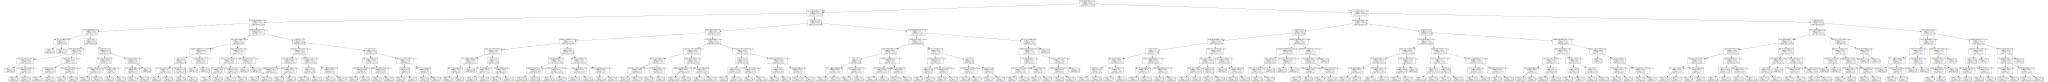

In [133]:
import graphviz 
dot_data = tree.export_graphviz(model, out_file=None, 
                                feature_names=feature_list,
                                special_characters=True, max_depth=8)
graph = graphviz.Source(dot_data)
graph

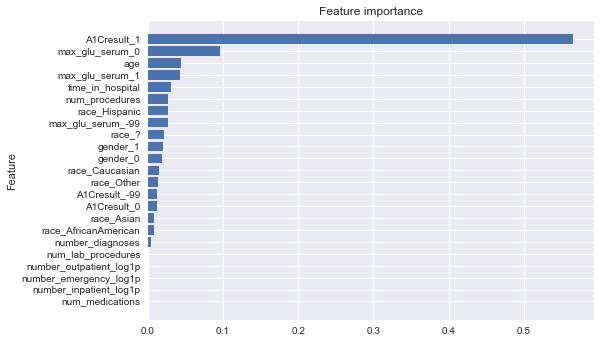

In [120]:
X = train_input[feature_list].astype(int)
Y = train_output.astype(int)
model_single_tree = tree.DecisionTreeClassifier(criterion='entropy',max_depth=8)
model_single_tree.fit(X, Y)

features = feature_list
importances = model_single_tree.feature_importances_
idx = np.argsort(importances)
plt.title("Feature importance")
plt.barh(range(len(idx)), importances[idx])
plt.yticks(range(len(idx)), [features[i] for i in idx])
plt.ylabel("Feature")
plt.show()

In [126]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

X = train_input[feature_list].astype(int)
Y = train_output.astype(int)

param_grid_forest = {'n_estimators': [10,30,50],
                     'max_depth': [5,6,7,8],
                     'min_samples_leaf': [10,11,12,13,14]}
grid_forest = GridSearchCV(RandomForestClassifier(criterion='entropy'), param_grid_forest, cv=10)
grid_forest.fit(X, Y)
best_RandomForest = grid_forest.best_params_
print('Best parameters: {}'.format(best_RandomForest))
print('Best score on training set: {:.2f}'.format(grid_forest.best_score_))

Best parameters: {'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 10}
Best score on training set: 0.59


In [130]:
from sklearn import metrics
X_train, X_dev, Y_train, Y_dev = train_test_split(train_input[feature_list], train_output, test_size=0.20, random_state=0)
Y_dev = Y_dev.astype(int)
Y_train = Y_train.astype(int)

clf = grid_forest
# train accuracy
y_train_predict = clf.predict(X_train)
train_accuracy = metrics.accuracy_score(Y_train, y_train_predict)
train_recall = metrics.recall_score(Y_train, y_train_predict)
train_precision = metrics.precision_score(Y_train, y_train_predict)
# test accuracy
y_test_predict = clf.predict(X_dev)
test_accuracy = metrics.accuracy_score(Y_dev, y_test_predict)
test_recall  = metrics.recall_score(Y_dev, y_test_predict)
test_precision = metrics.precision_score(Y_dev, y_test_predict)



In [132]:
print(train_accuracy, train_recall, train_precision)
print(test_accuracy, test_recall, test_precision)

0.579105048445 0.0704413731609 0.576642335766
0.578276389597 0.0679342444048 0.572621035058


In [168]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
X_train, X_dev, Y_train, Y_dev = train_test_split(train_input[feature_list], train_output, test_size=0.20, random_state=0)
Y_dev = Y_dev.astype(int)
Y_train = Y_train.astype(int)
logreg = LogisticRegression(fit_intercept=True)
print("Cross Validation Score: {:.2%}".format(np.mean(cross_val_score(logreg, X_train, Y_train, cv=25))))
logreg.fit(X_train, Y_train)
print("Dev Set score: {:.2%}".format(logreg.score(X_dev, Y_dev)))

Cross Validation Score: 63.01%
Dev Set score: 63.80%


In [169]:
[print(fname, coeffs) for fname, coeffs in zip(X_train.columns, np.round(logreg.coef_[0],3))];

time_in_hospital 0.011
num_medications 6.299
num_procedures -0.835
number_diagnoses -0.115
number_inpatient_log1p -0.628
number_emergency_log1p 1.259
number_outpatient_log1p 0.469
num_lab_procedures -0.186
race_? -0.04
race_AfricanAmerican -0.091
race_Asian -0.173
race_Caucasian -0.167
race_Hispanic 0.042
race_Other 0.06
gender_0 -0.246
gender_1 -0.123
age -0.407
max_glu_serum_-99 0.046
max_glu_serum_0 -0.599
max_glu_serum_1 0.184
A1Cresult_-99 -0.292
A1Cresult_0 -0.405
A1Cresult_1 0.329


In [174]:
from sklearn.svm import SVC, LinearSVC
clf = SVC(kernel='linear', cache_size=7000, verbose=True)
# print("Cross Validation Score: {:.2%}".format(np.mean(cross_val_score(clf, X_train, Y_train, cv=25))))
clf.fit(X_train, Y_train)
print("Dev Set score: {:.2%}".format(clf.score(X_dev, Y_dev)))

[LibSVM]Dev Set score: 63.22%


In [175]:
clf2 = SVC(kernel='poly', cache_size=7000, verbose=True)
clf2.fit(X_train, Y_train)
print("Dev Set score: {:.2%}".format(clf2.score(X_dev, Y_dev)))

[LibSVM]Dev Set score: 59.11%


In [176]:
clf3 = SVC(kernel='rbf', cache_size=7000, verbose=True)
clf3.fit(X_train, Y_train)
print("Dev Set score: {:.2%}".format(clf3.score(X_dev, Y_dev)))

[LibSVM]Dev Set score: 62.60%
